# Exercise: TKO_3120 Machine Learning and Pattern Recognition

# The problem
CIFAR-10 is a dataset consist of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. The test images are composed of 1000 randomly selected images from each class. The training images contains 5,000 images from each class in random order. The goal of this execrisce, is to build an algorithm which takes a random image and classify it to one of the 10 classes with as high as possible accuracy.

# Import Packages
Import all the packages needed for this notebook in one cell

In [1]:
import numpy as np, cv2
import os
import platform
from six.moves import cPickle as pickle

import time
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

from sklearn.neural_network import MLPClassifier

In [2]:
timer_start = time.time()

# Load the raw CIFAR-10 data

Donwnload the dataset from the zip file (cifar-10-batches-py) in moodle. Then unzip the file. 

In [3]:
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

In [4]:
def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

In [5]:
def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X, Y

In [6]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cifar10/cifar10'
# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


# Data Visualization

Show a few examples of training images from each class.

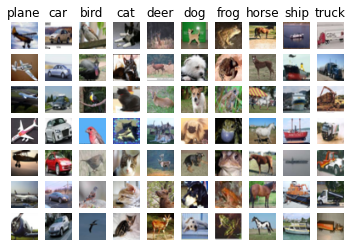

In [7]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

# Feature extraction



## 1- Color Mean and Standard Deviation
**Question (1 point):** 
Calculate the below mentioned color features for each image:

- Mean for each RGB color channel
- Standard Deviation (STD) for each RGB color channel


In [8]:
# Combine X_train and X_test back to X_all for feature extraction (mean, std, histogram and lbp)
X_all = np.concatenate((X_train, X_test))
print(X_all.shape)

(60000, 32, 32, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

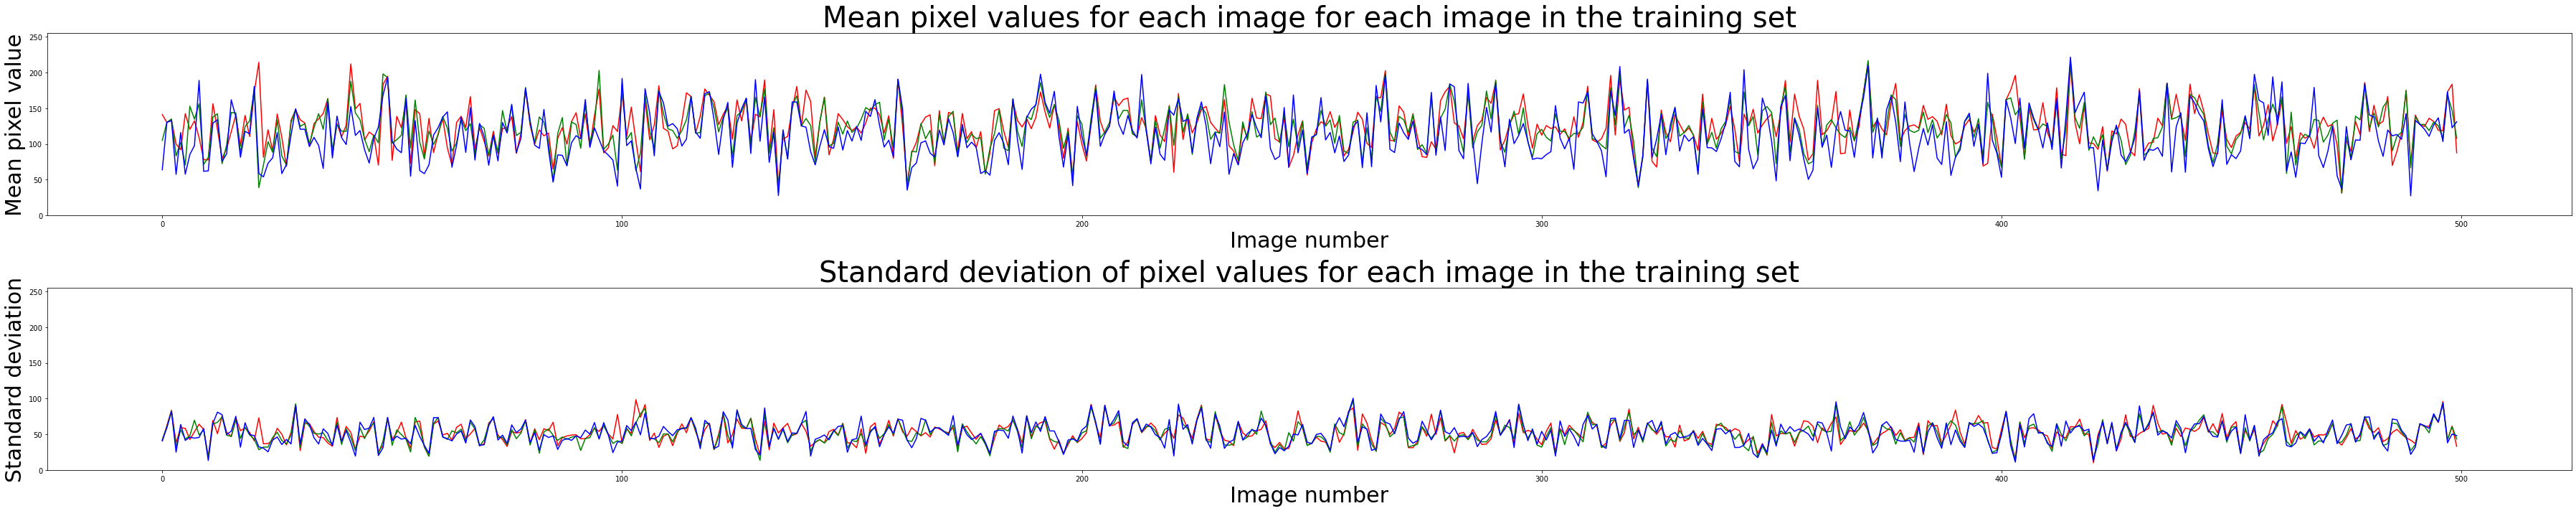

In [9]:
# X_train shape = 50000, 32, 32, 3
r = X_all[:,:,:,0] # all red channels
g = X_all[:,:,:,1] # all green channels
b = X_all[:,:,:,2] # all blue channels

r_means = np.mean(r, axis=(1,2)) # red channel mean for every image
g_means = np.mean(g, axis=(1,2)) # green channel mean for every image
b_means = np.mean(b, axis=(1,2)) # blue channel mean for every image

r_std = np.std(r, axis=(1,2)) # red channel standard deviation for every image
g_std = np.std(g, axis=(1,2)) # green channel standard deviation for every image
b_std = np.std(b, axis=(1,2)) # blue channel standard deviation for every image

fig, axes = plt.subplots(2,1,figsize=(50,10))

# plotting the color channel means for the first 500 images
plt.subplot(2,1,1)
plt.plot(np.arange(500), r_means[:500], 'r')
plt.plot(np.arange(500), g_means[:500], 'g')
plt.plot(np.arange(500), b_means[:500], 'b')
plt.title("Mean pixel values for each image for each image in the training set", fontsize=40)
plt.xlabel("Image number", fontsize=30)
plt.ylabel("Mean pixel value", fontsize=30)
plt.ylim([0,255])

# plotting the color channel standard deviations for the first 500 images
plt.subplot(2,1,2)
plt.plot(np.arange(500), r_std[:500], 'r')
plt.plot(np.arange(500), g_std[:500], 'g')
plt.plot(np.arange(500), b_std[:500], 'b')
plt.title("Standard deviation of pixel values for each image in the training set", fontsize=40)
plt.xlabel("Image number", fontsize=30)
plt.ylabel("Standard deviation", fontsize=30)
plt.ylim([0,255])

plt.tight_layout()
plt.show


## 2- Color Histograms
**Question (1 point):**

   Obtain histogram feature  (e.g. cv2.calcHist from OpenCV) for each of RGB channel with 8 bins per channel. 

In [10]:
# Make a histogram for every color channel for every image
# A single image here (img) is of type float64 and calcHist didn's seem to accept it so converted to uint8
# calcHist params: [0] for grayscale image, no mask, 8 bins, range of 0,255
# [:,0] returns only the histogram data and no bin values
r_hist = np.array([cv2.calcHist([img.astype(np.uint8)], [0], None, [8], [0,255])[:,0] for img in r])
g_hist = np.array([cv2.calcHist([img.astype(np.uint8)], [0], None, [8], [0,255])[:,0] for img in g])
b_hist = np.array([cv2.calcHist([img.astype(np.uint8)], [0], None, [8], [0,255])[:,0] for img in b])
print("Histograms created!")

Histograms created!


## 3- Local Binary Patterns (LBP)
**Question (1 point):**
Create Local Binary Pattern of each image 

    

In [11]:
# Convert RGB images to grayscale with luminosity method for lbp
g = np.dot(X_all[...,:3], [0.299, 0.587, 0.114])
print(g.shape)

(60000, 32, 32)


In [12]:
# Settings for local binary patterns
radius = 1
points = 8 * radius

lbps = np.array([local_binary_pattern(g_img, points, radius, 'uniform') for g_img in g])
lbps = lbps.reshape((60000,32*32)) # flatten the image data
print(lbps.shape)

(60000, 1024)


Gather all features (Mean, std, HIS and LBP) into an input array X, and the image classes into an output array y. Standardize the
feature values in X. One standard way of doing it is zscore normalization, meaning that the feature values will have zero mean and unit variance.

In [13]:
print("Original shapes of features:")
print(r_means.shape, g_means.shape, b_means.shape,
      r_std.shape, g_std.shape, b_std.shape,
      r_hist.shape, g_hist.shape, b_hist.shape,
      lbps.shape)
print()
# Join the features into a single array
features = np.hstack([r_means[:, None], g_means[:, None], b_means[:, None],
                      r_std[:, None], g_std[:, None], b_std[:, None],
                      r_hist, g_hist, b_hist,
                      lbps])
print("New shape:",features.shape)

Original shapes of features:
(60000,) (60000,) (60000,) (60000,) (60000,) (60000,) (60000, 8) (60000, 8) (60000, 8) (60000, 1024)

New shape: (60000, 1054)


In [14]:
# At what point should I split the training and test data after extracting features?
# for now doing it here, before scaling and scaling them separately.abs
# Not sure if scaling should be done before or after but pca definitely after and only on training data
X_train = features[:50000]
X_test = features[50000:]

In [15]:
# Standardization with sklearn standard scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Scaling done!")


Scaling done!


## PCA 
**Question (1 point):** 

Use PCA with 10 component to reduce dimension of the feature vector X.

In [16]:
# PCA
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_scaled) # Choose the 10 components from training data
X_test_pca = pca.transform(X_test_scaled) # Select those component also from test data
print(X_train_pca.shape)
print(X_test_pca.shape)

(50000, 10)
(10000, 10)


# Build classifiers and estimate their performance

## 1- K-Nearest Neighbor (K-NN) 

In this exercise you will implement a K-NN classifier and understand the basic Image Classification pipeline and  cross-validation.

**Question (2 points):** 

Perform 5-fold cross validation to find the best value of k in range 1 to 30. For each possible value of k, run the k-nearest-neighbor algorithm num_folds times (5),   where in each case you use all but one of the folds as training data and the last fold as a validation set.                   



In [17]:
# Looks to me we're supposed to use here the X_train created in the beginning (50000 images), and split that again into 5-fold training and test sets.
#  And later when the best k value is chosen, train with the whole of X_train
X_train = X_train_pca
X_test = X_test_pca
y_train, y_test = y_train, y_test # Unchanged from beginning

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(50000, 10) (10000, 10) (50000,) (10000,)


In [132]:
start = time.time()

# Parameter set-up
num_folds = 5
k_vals = np.arange(1,31)

# Train-test splitter
kf = KFold(n_splits=num_folds)

avg_acc = []
for k in k_vals:
    print("k:",k)

    scores = []
    
    for train_index, test_index in kf.split(X_train):
        X_train_k, X_test_k = X_train[train_index], X_train[test_index] # _k to not mess with LR and MLP
        y_train_k, y_test_k = y_train[train_index], y_train[test_index]

        knn = KNeighborsClassifier(n_neighbors=k)

        knn.fit(X_train_k, y_train_k)

        score = knn.score(X_test_k, y_test_k)

        scores.append(score)
        print(score)
    
    avg_acc.append(np.mean(scores)) # Add average of repeat scores to list

    print(f"Time for k={k}:",round(time.time()-start,2))

print("Best value for k was:", avg_acc.index(np.max(avg_acc)) + 1, "at", np.max(avg_acc))
print("Ending time:", round(time.time()-start,2))
# Took 820 s for me


k: 1
0.182
0.1955
0.1833
0.1907
0.1866
Time for k=1: 14.75
k: 2
0.1821
0.1877
0.1777
0.1904
0.1776
Time for k=2: 33.0
k: 3
0.1969
0.1975
0.1944
0.1973
0.1879
Time for k=3: 51.6
k: 4
0.2059
0.2105
0.2095
0.2078
0.2011
Time for k=4: 70.55
k: 5
0.215
0.215
0.2146
0.2161
0.2101
Time for k=5: 90.35
k: 6
0.2164
0.2188
0.2225
0.2251
0.215
Time for k=6: 112.01
k: 7
0.2189
0.2229
0.2253
0.2254
0.2211
Time for k=7: 133.77
k: 8
0.2216
0.2274
0.2268
0.2275
0.224
Time for k=8: 155.99
k: 9
0.2282
0.2327
0.2327
0.2328
0.2257
Time for k=9: 180.37
k: 10
0.2284
0.2333
0.2369
0.2345
0.2302
Time for k=10: 204.04
k: 11
0.2288
0.2385
0.2393
0.24
0.2341
Time for k=11: 228.81
k: 12
0.2333
0.2405
0.241
0.2403
0.2364
Time for k=12: 256.34
k: 13
0.2317
0.2407
0.2438
0.2396
0.2379
Time for k=13: 281.32
k: 14
0.2327
0.2445
0.242
0.2426
0.2387
Time for k=14: 306.92
k: 15
0.2378
0.2433
0.2447
0.2434
0.2401
Time for k=15: 332.68
k: 16
0.2404
0.2469
0.2489
0.2437
0.24
Time for k=16: 359.35
k: 17
0.2407
0.2521
0.2455
0

**Question (1 point):** 

- Plot the Cross-validated accuracy based on the different value of k

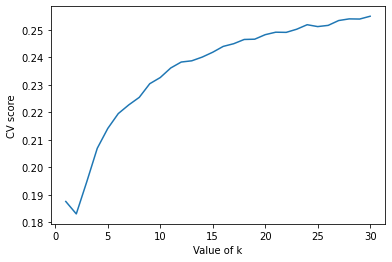

In [133]:
plt.plot(np.arange(1,31), avg_acc)
plt.xlabel("Value of k")
plt.ylabel("CV score")
plt.show()


**Questions (2 points):** 
    
- Based on the cross-validation results above, choose the best value for k,   

- Retrain the classifier using all the training data, and test it on the test data. 

- What is the accuracy value for the test data?

In [134]:
k = 30 #best value of k based on the cv

knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)
score = knn.score(X_test, y_test)
print(score)


0.2655


## 2- Logistic Regression (LR)


In this exercise you will implement a LR classifier.

**Question (2 points):** 

- Create and train the Logistic Regression model
- Calculate the accuracy and the confusion matrix on test dataset

              precision    recall  f1-score   support

       plane       0.27      0.33      0.30      1000
         car       0.20      0.16      0.18      1000
        bird       0.16      0.12      0.13      1000
         cat       0.11      0.04      0.06      1000
        deer       0.25      0.35      0.29      1000
         dog       0.19      0.27      0.23      1000
        frog       0.27      0.38      0.31      1000
       horse       0.23      0.09      0.13      1000
        ship       0.21      0.23      0.22      1000
       truck       0.25      0.32      0.28      1000

    accuracy                           0.23     10000
   macro avg       0.21      0.23      0.21     10000
weighted avg       0.21      0.23      0.21     10000


Accuracy: 0.227



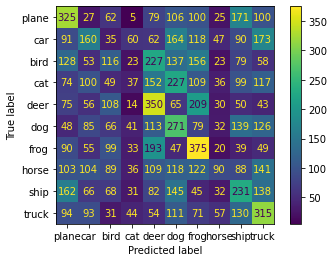

In [135]:
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

le = LabelEncoder()
le.fit(classes)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()

print(classification_report(y_test, y_pred, target_names=classes))
print()
print("Accuracy:",accuracy_score(y_test, y_pred))
print()

## 3- Multilayer perceptron 
In this exercise you will develop a neural network with one hidden layer to perform classification.

Use:

- solver for weight optimization: stochastic gradient-based optimizer ('sgd')
- activation function for the hidden layer: rectified linear unit function ('relu')
- Early stop

**Questions (3 points):** 
- What is the prediction accuracy for the test data?
-  To evaluate the MLP model, calculate the metrics such as a confusion matrix, precision, recall, and f1 score. 
-  Show the predicted results (classification lable) on 5 random example of test dataset.
- Show 5 random of wrong predictions

In [136]:
# Training the multilayer perceptron
mlp_clf = MLPClassifier(solver='sgd', activation='relu', alpha=1e-5, hidden_layer_sizes=(100,), random_state=1, early_stopping=True)
mlp_clf.fit(X_train, y_train)

MLPClassifier(alpha=1e-05, early_stopping=True, random_state=1, solver='sgd')

In [137]:
# Print some predictions
y_pred = mlp_clf.predict(X_test)
print(y_pred)
print(y_test)

[6 8 9 ... 3 1 4]
[3 8 8 ... 5 1 7]


In [138]:
print("Accuracy for MLP:", accuracy_score(y_test, y_pred))

Accuracy for MLP: 0.2877


              precision    recall  f1-score   support

       plane       0.36      0.37      0.36      1000
         car       0.27      0.29      0.28      1000
        bird       0.31      0.20      0.24      1000
         cat       0.24      0.09      0.13      1000
        deer       0.28      0.27      0.27      1000
         dog       0.26      0.26      0.26      1000
        frog       0.33      0.47      0.39      1000
       horse       0.26      0.23      0.25      1000
        ship       0.27      0.26      0.26      1000
       truck       0.28      0.44      0.34      1000

    accuracy                           0.29     10000
   macro avg       0.28      0.29      0.28     10000
weighted avg       0.28      0.29      0.28     10000


Accuracy: 0.2877



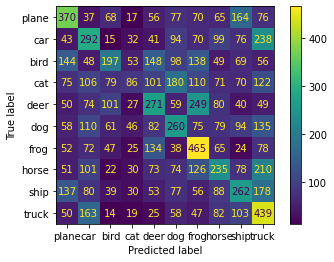

In [139]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()

print(classification_report(y_test, y_pred, target_names=classes))
print()
print("Accuracy:",accuracy_score(y_test, y_pred))
print()

In [142]:
# 5 random examples
print("5 random examples:")
ids = np.random.choice(np.arange(len(y_test)), 5, replace=False)
print("True values:",y_test[ids])
print("Predicted values:",y_pred[ids])
print()

# 5 random wrong examples
print("5 examples of wrong classification")

ids = np.random.choice(np.arange(len(y_test)), 5, replace=False)
k = 0
while k != 5:
    # Try getting 5 new samples until they are all wrongly classified
    for i in ids:
        if y_test[i] == y_pred[i]:
            ids = np.random.choice(np.arange(len(y_test)), 5, replace=False)
            break
        k = k + 1
        print("...")
print("True values:",y_test[ids])
print("Predicted values:",y_pred[ids])


5 random examples:
True values: [6 1 6 4 9]
Predicted values: [0 0 4 9 1]

5 examples of wrong classification
...
...
...
...
...
True values: [0 3 6 8 9]
Predicted values: [0 3 9 1 9]


In [144]:
timer_end = time.time()
total = round((timer_end - timer_start) / 60)
print("Total time taken was", total, "minutes!")

Total time taken was 17 minutes!


Ending time for me was 17 minutes. 